# tryna solve poisson's equation with conv neural net

poisson's equation
\begin{equation}
\nabla^{2}V = -\rho
\end{equation}
where V is the electrostatic potential and rho is charge density

we also want dirichlet boundary conditions, where V is zero at the boundary of the region we care about

the equation is discretized with
\begin{equation}
\delta_{x}^{2} = \frac{1}{h^2}(w_{i+1,j} - 2w_{i,j} + w_{i-1,j})
\end{equation}

\begin{equation}
\delta_{y}^{2} = \frac{1}{h^2}(w_{i,j+1} - 2w_{i,j} + w_{i,j-1})
\end{equation}

where w is the approximation of V at i,j and h is the distance between grid points. This gives:

\begin{equation}
-(w_{i-1,j} + w_{i,j-1} - 4w_{i,j} + w_{i+1,j} + w_{i,j+1}) = h^2 f_{i,j}
\end{equation}

for i from 1 to N-1 and j from 1 to N-1. This can be represented as a system of N-1 equations, shown in matrix form

\begin{equation}
Aw = r
\end{equation}

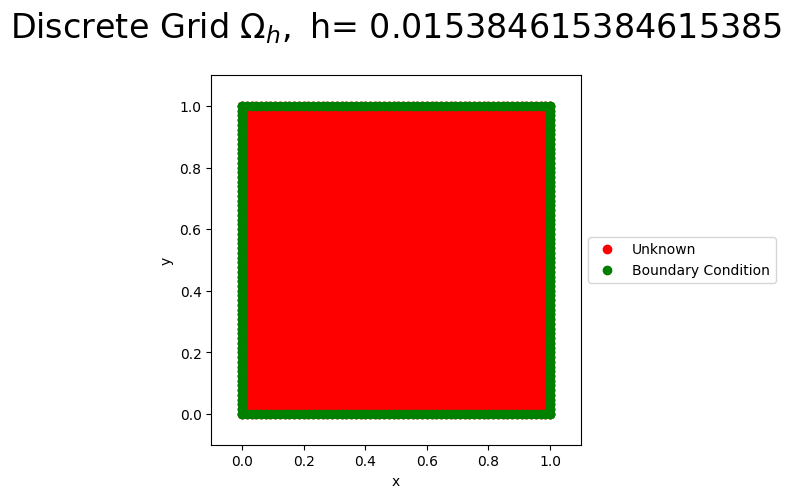

In [1]:
# LIBRARY
# vector manipulation
import numpy as np
import random as rd

# THIS IS FOR PLOTTING
import matplotlib.pyplot as plt # side-stepping mpl backend

N=65
h=1/N
x=np.arange(0,1.0001,h)
y=np.arange(0,1.0001,h)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
plt.plot(x[1],y[1],'ro',label='Unknown');
plt.plot(X,Y,'ro');
plt.plot(np.ones(N+1),y,'go',label='Boundary Condition');
plt.plot(np.zeros(N+1),y,'go');
plt.plot(x,np.zeros(N+1),'go');
plt.plot(x, np.ones(N+1),'go');
plt.xlim((-0.1,1.1))
plt.ylim((-0.1,1.1))
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Discrete Grid $\Omega_h,$ h= %s'%(h),fontsize=24,y=1.08)
plt.show()

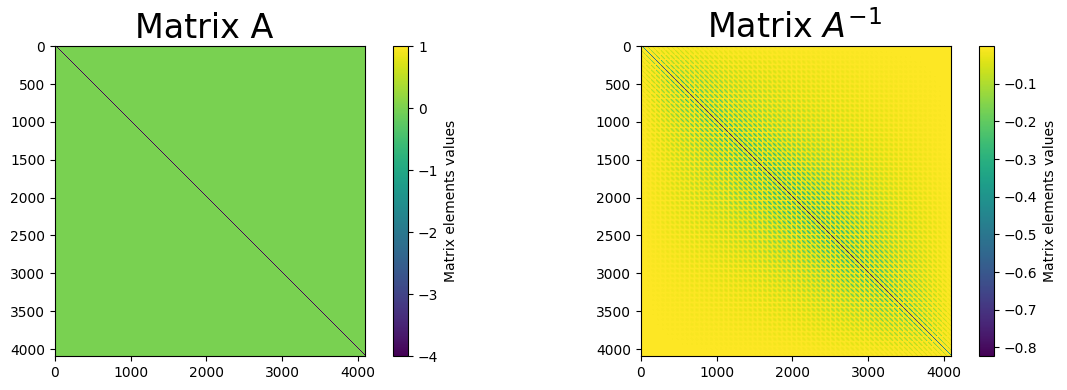

In [2]:
N2=(N-1)*(N-1)
A=np.zeros((N2,N2))
## Diagonal            
for i in range (0,N-1):
    for j in range (0,N-1):           
        A[i+(N-1)*j,i+(N-1)*j]=-4

# LOWER DIAGONAL        
for i in range (1,N-1):
    for j in range (0,N-1):           
        A[i+(N-1)*j,i+(N-1)*j-1]=1   
# UPPPER DIAGONAL        
for i in range (0,N-2):
    for j in range (0,N-1):           
        A[i+(N-1)*j,i+(N-1)*j+1]=1   

# LOWER IDENTITY MATRIX
for i in range (0,N-1):
    for j in range (1,N-1):           
        A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
# UPPER IDENTITY MATRIX
for i in range (0,N-1):
    for j in range (0,N-2):           
        A[i+(N-1)*j,i+(N-1)*(j+1)]=1
Ainv=np.linalg.inv(A)   
fig = plt.figure(figsize=(12,4));
plt.subplot(121)
plt.imshow(A,interpolation='none');
clb=plt.colorbar();
clb.set_label('Matrix elements values');
plt.title('Matrix A ',fontsize=24)
plt.subplot(122)
plt.imshow(Ainv,interpolation='none');
clb=plt.colorbar();
clb.set_label('Matrix elements values');
plt.title(r'Matrix $A^{-1}$ ',fontsize=24)

fig.tight_layout()
plt.show();

def calc_approx(rho):
    w=np.zeros((N+1,N+1))

    for i in range (0,N):
        w[i,0]=0 #left Boundary
        w[i,N]=0 #Right Boundary

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary

    r=np.zeros(N2)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):           
            r[i+(N-1)*j]=-rho[j][i]

    # Boundary makes no contribution in the case of Dirichlet conditions

    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    ret = np.zeros((32,32))
    for i in range(32):
        for j in range(32):
            ret[i][j] = w[16+i][16+j] 
    return ret

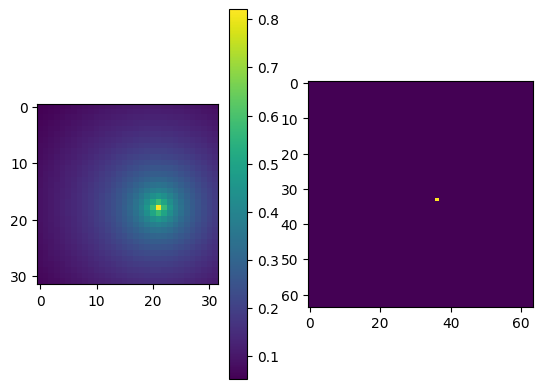

In [3]:
def rand_point_charge_distr():
    rho = np.zeros((N-1, N-1))
    interval = int((N)/4)
    i = rd.randint(1+interval,N-2-interval)
    j = rd.randint(1+interval,N-2-interval)
    # rho[i][j] = rd.uniform(1)
    rho[i][j] = 1
    return rho

rho = rand_point_charge_distr()

w = calc_approx(rho)

plt.subplot(1,2,1)
plt.imshow(w)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rho)

In [4]:
train_rho = []
train_V = []
for i in range(1000):
    new_rho = rand_point_charge_distr()
    new_V = calc_approx(new_rho)
    train_rho.append(new_rho)
    train_V.append(new_V)

test_rho = []
test_V = []
for i in range(1000):
    new_rho = rand_point_charge_distr()
    new_V = calc_approx(new_rho)
    test_rho.append(new_rho)
    test_V.append(new_V)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(16, (11, 11), activation='relu', input_shape=[N-1, N-1, 1]))
model.add(layers.Conv2D(32, (11, 11), activation='relu'))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (1, 1), activation='relu'))
model.add(layers.Conv2D(1, (1, 1), activation='relu'))

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

c:\Users\jawsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 16)     │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │        61,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,769 (1.28 MB)

 Trainable params: 336,769 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(np.array(train_rho), np.array(train_V), epochs=80, batch_size=32)

Epoch 1/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 0.1055
Epoch 2/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0281
Epoch 3/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0192
Epoch 4/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.0163
Epoch 5/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0144
Epoch 6/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.0134
Epoch 7/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0135
Epoch 8/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0127
Epoch 9/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0126
Epoch 10/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.0125
Epoch 11/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.0132
Epoch 12/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.0118
Epoch 13/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.0119
Epoch 14/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0118
Epoch 15/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - lo

In [7]:
pred = model.predict(np.array(test_rho))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


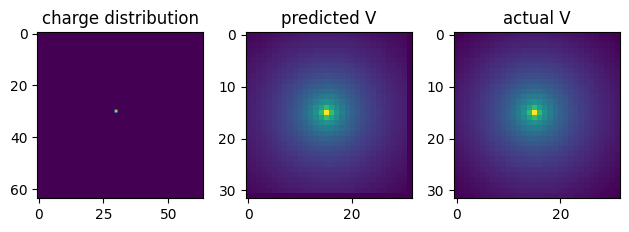

In [27]:
test_number = 9

plt.subplot(1,3,1)
plt.title("charge distribution")
plt.imshow(test_rho[test_number])
plt.subplot(1,3,2)
plt.title("predicted V")
plt.imshow(pred[test_number])
# plt.colorbar()
plt.subplot(1,3,3)
plt.title("actual V")
plt.imshow(test_V[test_number])
# plt.colorbar()
plt.tight_layout()

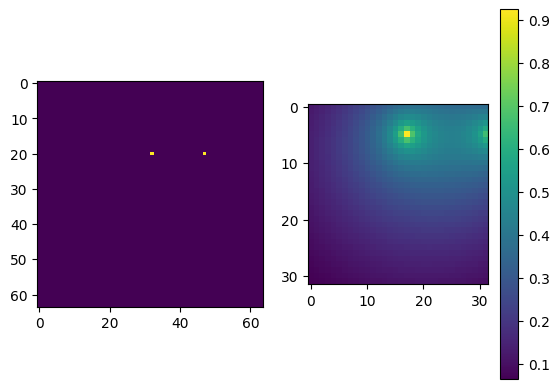

In [9]:
def rand_double_point_charge_distr():
    rho = np.zeros((N-1, N-1))
    interval = int((N)/4)
    i1 = rd.randint(1+interval,N-2-interval)
    j1 = rd.randint(1+interval,N-2-interval)
    q1 = rd.uniform(5,20)
    i2 = rd.randint(1+interval,N-2-interval)
    j2 = rd.randint(1+interval,N-2-interval)
    q2 = rd.uniform(5,20)
    rho[i1][j1] = 1
    rho[i2][j2] = 1
    return rho

rho = rand_double_point_charge_distr()

w = calc_approx(rho)

plt.subplot(1,2,2)
plt.imshow(w)
plt.colorbar()
plt.subplot(1,2,1)
plt.imshow(rho)

In [10]:
test_rho_double = []
test_V_double = []
for i in range(100):
    new_rho = rand_double_point_charge_distr()
    new_V = calc_approx(new_rho)
    test_rho_double.append(new_rho)
    test_V_double.append(new_V)

pred_double = model.predict(np.array(test_rho_double))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


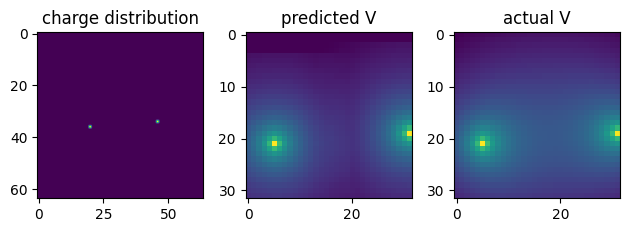

In [35]:
test_number = 8

plt.subplot(1,3,1)
plt.title("charge distribution")
plt.imshow(test_rho_double[test_number])
plt.subplot(1,3,2)
plt.title("predicted V")
plt.imshow(pred_double[test_number])
# plt.colorbar()
plt.subplot(1,3,3)
plt.title("actual V")
plt.imshow(test_V_double[test_number])
# plt.colorbar()
plt.tight_layout()

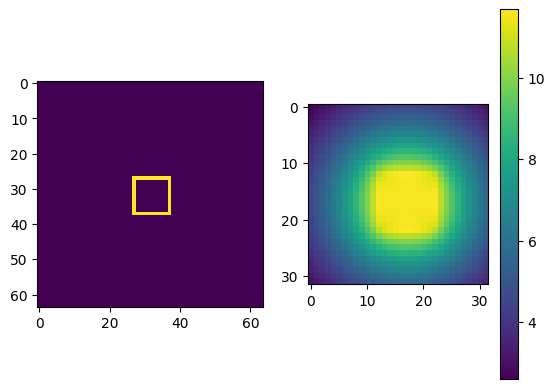

In [12]:
def square_charge_distr(d):
    rho = np.zeros((N-1, N-1))
    d_2 = int(d/2)
    middle = int((N-1)/2)
    for i in range(middle-d_2, middle+d_2+1):
        rho[middle-d_2][i] = 1  # top
        rho[middle+d_2][i] = 1  # bottom
        rho[i][middle-d_2] = 1  # left
        rho[i][middle+d_2] = 1  # right
    return rho

rho = square_charge_distr(10)

w = calc_approx(rho)

plt.subplot(1,2,2)
plt.imshow(w)
plt.colorbar()
plt.subplot(1,2,1)
plt.imshow(rho)

In [13]:
test_rho_square = []
test_V_square = []
for i in range(4, 20):
    new_rho = square_charge_distr(i)
    new_V = calc_approx(new_rho)
    test_rho_square.append(new_rho)
    test_V_square.append(new_V)

pred_square = model.predict(np.array(test_rho_square))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


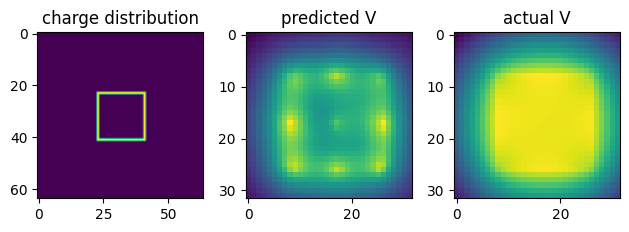

In [38]:
test_number = 14

plt.subplot(1,3,1)
plt.title("charge distribution")
plt.imshow(test_rho_square[test_number])
plt.subplot(1,3,2)
plt.title("predicted V")
plt.imshow(pred_square[test_number])
# plt.colorbar()
plt.subplot(1,3,3)
plt.title("actual V")
plt.imshow(test_V_square[test_number])
# plt.colorbar()
plt.tight_layout()

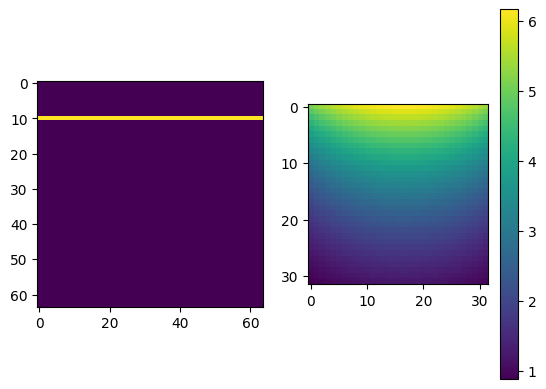

In [15]:
def line_charge_distr(i):
    rho = np.zeros((N-1, N-1))
    for j in range(N-1):
        rho[i][j] = 1
    return rho

rho = line_charge_distr(10)

w = calc_approx(rho)

plt.subplot(1,2,2)
plt.imshow(w)
plt.colorbar()
plt.subplot(1,2,1)
plt.imshow(rho)

In [16]:
test_rho_line = []
test_V_line = []
for i in range(10, 50):
    new_rho = line_charge_distr(i)
    new_V = calc_approx(new_rho)
    test_rho_line.append(new_rho)
    test_V_line.append(new_V)

pred_line = model.predict(np.array(test_rho_line))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


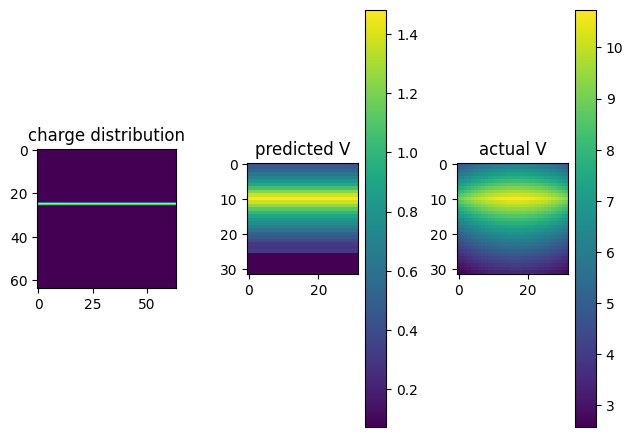

In [17]:
test_number = 15

plt.subplot(1,3,1)
plt.title("charge distribution")
plt.imshow(test_rho_line[test_number])
plt.subplot(1,3,2)
plt.title("predicted V")
plt.imshow(pred_line[test_number])
plt.colorbar()
plt.subplot(1,3,3)
plt.title("actual V")
plt.imshow(test_V_line[test_number])
plt.colorbar()
plt.tight_layout()